In [1]:
from airsenal.framework.utils import session
from airsenal.framework.bpl_interface import get_fitted_team_model
from airsenal.framework.season import get_current_season, CURRENT_TEAMS

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
from bpl import ExtendedDixonColesMatchPredictor

In [3]:
season = "2021"
next_gw = 5

model_team = get_fitted_team_model(season=season,
                                   gameweek=next_gw,
                                   dbsession=session,
                                   ratings=True,
                                   model=ExtendedDixonColesMatchPredictor(),
                                   epsilon=1.0)

Fitting team model (<class 'bpl.extended_dixon_coles.ExtendedDixonColesMatchPredictor'>)...
Fitting <bpl.extended_dixon_coles.ExtendedDixonColesMatchPredictor object at 0x16a918790> model with epsilon = 1.0


sample: 100%|██████████| 1500/1500 [00:03<00:00, 433.22it/s, 31 steps of size 9.72e-02. acc. prob=0.91] 


## Get Actual Match Results from Database

In [12]:
query = (
    session.query(Result, Fixture.season, Fixture.gameweek, Fixture.home_team, Fixture.away_team)
    .filter(Fixture.gameweek >= next_gw)
    .filter(Fixture.season == season)
    .join(Fixture)
)
results = pd.read_sql(query.statement, session.bind)

results.head()

In [13]:
max_goals = 10


def score_error(actual, goal_preds):
    return sum(abs(actual - i) * goal_preds[i] for i in range(max_goals))


def exp_goals(goal_preds):
    return sum([n*goal_preds[n] for n in range(max_goals)])/sum(goal_preds)


for i, row in results.iterrows():
    team_h = row["home_team"]
    team_a = row["away_team"]
    actual_h = row["home_score"]
    actual_a = row["away_score"]
    
    prob_score_h = [model_team.score_n_probability(n, team_h, team_a) for n in range(max_goals)]
    prob_score_a = [model_team.score_n_probability(n, team_a, team_h, home=False) for n in range(max_goals)]

    exp_h = exp_goals(prob_score_h)
    exp_a = exp_goals(prob_score_a)
    results.loc[i, "pred_home"] = exp_h
    results.loc[i, "pred_away"] = exp_a
    
    err_h = score_error(actual_h, prob_score_h)
    err_a = score_error(actual_a, prob_score_a)
    results.loc[i, "home_error"] = err_h
    results.loc[i, "away_error"] = err_a
    

results["home_diff"] = results["home_score"] - results["pred_home"]
results["away_diff"] = results["away_score"] - results["pred_away"]


In [47]:
results

,result_id,fixture_id,home_score,away_score,player_id,season,gameweek,home_team,away_team,pred_home,pred_away,home_error,away_error,home_diff,away_diff
0,1179,1182,2,2,None,2021,5,EVE,LIV,1.055435,1.968919,1.185326,1.082896,0.944565,0.031081
1,1180,1183,3,3,None,2021,5,CHE,SOU,2.065528,0.771533,1.419626,2.247793,0.934472,2.228467
2,1181,1184,1,0,None,2021,5,MCI,ARS,2.608716,1.044765,1.757635,1.044765,-1.608716,-1.044765
3,1182,1185,1,4,None,2021,5,NEW,MUN,1.079972,1.453167,0.761056,2.590293,-0.079972,2.546833
4,1183,1186,1,1,None,2021,5,SHU,FUL,1.605974,0.779952,1.011536,0.699715,-0.605974,0.220048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,1253,1256,3,0,None,2021,12,SOU,SHU,1.207379,0.982064,1.883693,0.982064,1.792621,-0.982064
75,1254,1257,1,1,None,2021,12,CRY,TOT,1.001028,1.618897,0.738455,1.017873,-0.001028,-0.618897
76,1255,1258,1,1,None,2021,12,FUL,LIV,0.709895,2.816646,0.695375,1.937315,0.290105,-1.816646
77,1256,1259,0,1,None,2021,12,ARS,BUR,2.033984,0.949584,2.033860,0.725217,-2.033984,0.050416


In [48]:
pd.Series(results[["home_error", "away_error"]].values.flatten()).describe()

count    158.000000
mean       1.224433
std        0.516969
min        0.545707
25%        0.826770
50%        1.095852
75%        1.482518
max        3.794197
dtype: float64

In [69]:
results[["home_error", "away_error"]].describe()

,home_error,away_error
count,79.000000,79.000000
mean,1.236594,1.212272
std,0.445722,0.582214
min,0.695375,0.545707
25%,0.851484,0.786009
50%,1.115975,1.081299
75%,1.493250,1.360048
max,2.572724,3.794197


Text(0.5, 1.0, 'Away Error')

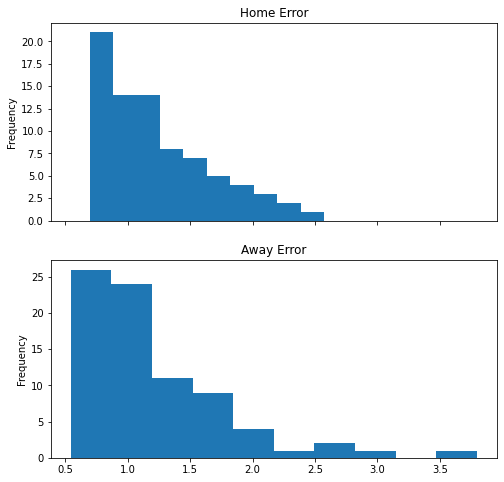

In [61]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

results["home_error"].plot.hist(ax=ax[0])
ax[0].set_title("Home Error")
results["away_error"].plot.hist(ax=ax[1])
ax[1].set_title("Away Error")


In [55]:
pd.Series(results[["home_diff", "away_diff"]].values.flatten()).abs().describe()

count    158.000000
mean       0.924408
std        0.691048
min        0.000363
25%        0.292214
50%        0.899741
75%        1.306239
max        3.790132
dtype: float64

In [73]:
results[["home_diff", "away_diff"]].abs().describe()

,home_diff,away_diff
count,79.000000,79.000000
mean,0.892377,0.956439
std,0.644011,0.737827
min,0.000363,0.031081
25%,0.301262,0.284814
50%,0.789996,0.921670
75%,1.330550,1.277158
max,2.525266,3.790132


Text(0.5, 1.0, 'Away Diff')

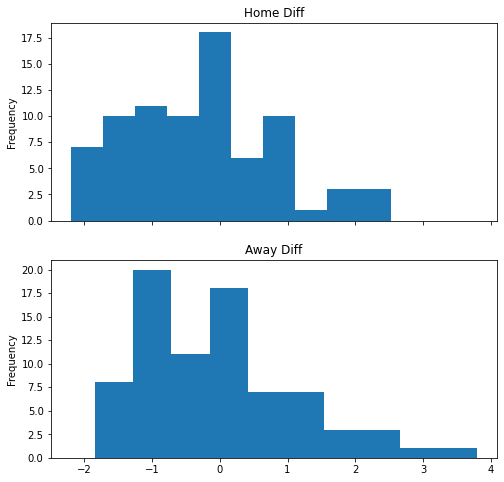

In [62]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

results["home_diff"].plot.hist(ax=ax[0])
ax[0].set_title("Home Diff")
results["away_diff"].plot.hist(ax=ax[1])
ax[1].set_title("Away Diff")


Text(0, 0.5, 'Actual Goals Scored')

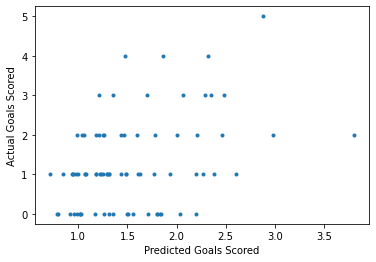

In [68]:
plt.plot(results["pred_home"], results["home_score"], ".")
plt.xlabel("Predicted Goals Scored")
plt.ylabel("Actual Goals Scored")

Text(0, 0.5, 'Actual Goals Scored')

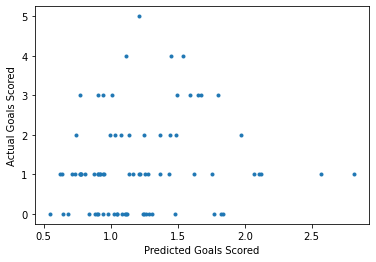

In [67]:
plt.plot(results["pred_away"], results["away_score"], ".")
plt.xlabel("Predicted Goals Scored")
plt.ylabel("Actual Goals Scored")

In [65]:
results[["pred_home", "home_score"]].corr()

,pred_home,home_score
pred_home,1.000000,0.388525
home_score,0.388525,1.000000


In [66]:
results[["pred_away", "away_score"]].corr()

,pred_away,away_score
pred_away,1.000000,0.139643
away_score,0.139643,1.000000
